© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/phd_students/seleznova/index.html) 2022

https://github.com/mselezniova/MSML22

Distributed under the [Creative Commons Attribution License](https://creativecommons.org/licenses/by/4.0/)

In [9]:
%matplotlib inline
%config InlineBackend.figure_format='svg'

import matplotlib
import matplotlib.pyplot as plt

import os

import numpy as np
import pandas as pd


import sys
sys.path.append('../../')

from utils import train_test_split, normalize

# Optimization methods

In all the previous classes, we used only gradient descent (GD) and its stochastic variations to train machine learning models. We made this choice since GD is the simplest numeric optimization method and it still guarantees to find a solution of a convex objective. However, other optimization algorithms (modifications of GD) are more commonly used in practice, especially for non-convex problems, such as neural networks. We will discuss several such modifications in this class and see how they improve training of the MLP model implemented in the previous class.

As in the class on GD, we will first illustrate the behavior of all the optimization methods on a quadratic form, i.e. we will consider the following optimization problem: 

$$\min_x{\dfrac{1}{2}x^TAx},$$
where $A\in\mathbb{R}^{2\times 2}, x\in\mathbb{R}^{2}$. We define a class of such objective function and their corresponding gradients:

In [10]:
class quadratic_form():
    def __init__(self,A):
        self.A = A
        
    def val(self, x):
        return 0.5*x.T@self.A@x
    
    def grad(self, x):
        return self.A@x

We will choose the following matrix $A$ with condition number $10$:
$$A =\begin{bmatrix} 
	1 & 0 \\
	0 & 10 \\
	\end{bmatrix},$$
so that our problem is not "too easy".

## Gradient descent

First, we observe the behavior of GD on our problem. Recall that a GD update of parameters $w$ is given by 
$$w^{(k+1)} = w^{(k)} - \eta \nabla_w f(w^{(k)}),$$
where $f$ is the objective function and $\eta$ is a constant learning rate.

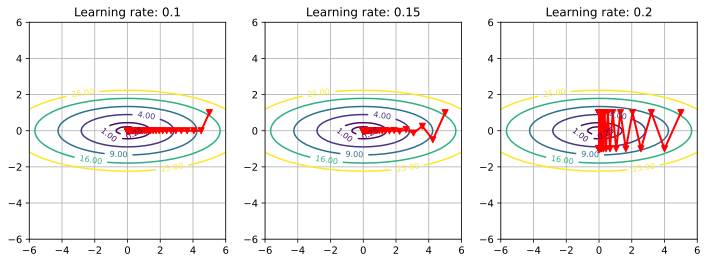

In [11]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

f = quadratic_form(np.array([[1,0],[0,10]]))

xrange = [-6, 6]
yrange = [-6, 6]
levels = [0, 0.25, 1, 4, 9, 16, 25]
        
x = np.linspace(xrange[0], xrange[1], 100)
y = np.linspace(yrange[0], yrange[1], 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i, j] = f.val(np.array([X[i, j], Y[i, j]]))

### Hyperparameters:
K = 100
lr_s = [0.1,0.15,0.2]
###

for ax_,lr in zip(ax,lr_s):
    
    CS = ax_.contour(X, Y, Z, levels=levels)
    ax_.clabel(CS, inline=1, fontsize=8) 
    ax_.grid()  
    
    x = np.array([5,1])
    history = [x]

    for k in range(K):
        x = x - lr*f.grad(x)
        history.append(x)

    history = np.array(history)
    ax_.plot(history[:,0],history[:,1],'-v', color='red', linewidth=2)
    ax_.set_title('Learning rate: '+str(lr))
    ax_.set_xlim(xrange)
    ax_.set_ylim(yrange)

As we have already seen before, GD oscillates between two sides of the narrow valley and fails to find the minimum if the learning rate is too big.

## Momentum 

Now we introduce the first modification of GD called **momentum**, which gives the gradients cummulative "memory" or "inertia". The update rule of GD with momentum is given by:

$$m^{(k+1)} = \alpha m^{(k)} + (1-\alpha)\nabla_w f(w^{(k)}) $$

$$w^{(k+1)} = w^{(k)} - \eta m^{(k+1)},$$

where $\alpha$ is a new hyperparameter, typically set around $0.9$. Let us test this optimization method on our quadratic problem:

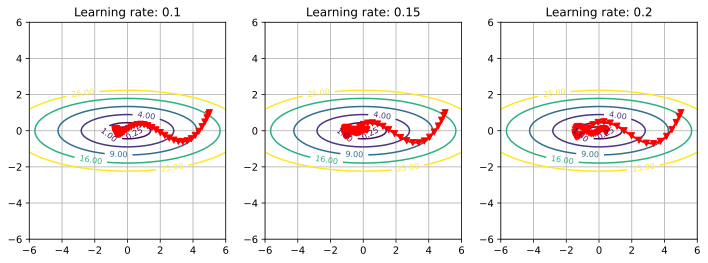

In [12]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

f = quadratic_form(np.array([[1,0],[0,10]]))



xrange = [-6, 6]
yrange = [-6, 6]
levels = [0, 0.25, 1, 4, 9, 16, 25]
        
x = np.linspace(xrange[0], xrange[1], 100)
y = np.linspace(yrange[0], yrange[1], 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i, j] = f.val(np.array([X[i, j], Y[i, j]]))

### Hyperparameters:
K = 50
lr_s = [0.1,0.15,0.2]
alpha = 0.9
###

for ax_,lr in zip(ax,lr_s):
    
    CS = ax_.contour(X, Y, Z, levels=levels)
    ax_.clabel(CS, inline=1, fontsize=8) 
    ax_.grid()  
    
    x = np.array([5,1])
    history = [x]
    
    prev_grad = 0.
    for k in range(K):
        
        grad = f.grad(x)
        m = alpha*prev_grad + (1.-alpha)*grad
        x = x - lr*m
        history.append(x)
        
        prev_grad = m

    history = np.array(history)
    ax_.plot(history[:,0],history[:,1],'-v', color='red', linewidth=2)
    ax_.set_title('Learning rate: '+str(lr))
    ax_.set_xlim(xrange)
    ax_.set_ylim(yrange)

One can see that momentum removes the oscillation problem of GD. Indeed, summing up the consequetive gradients, we zero out the opposite directions of those gradients. However, we can also see that the "inertial" makes the momentum method overstep the minimum, so the method needs more iterations to return to the minimum. Intuitively, this behavior of momentum methods can be compared to a heavy ball going down a slope.

## RMSprop

The second modification that we introduce is **adaptive learning rate**. Notice that GD runs into problems when the quadratic problem is poorly conditioned, i.e. the optimization landscaped is stretched over some directions more than over the other ones. In this case, gradients over some directions may be much larger than over the other ones and it is challenging to choose a single constant learning rate, which allows updates of all the directions. Adaptive learning rate methods, such as **RMSprop** address this problem by giving different learning rates to different variables. An update of RMSprop is given by:

$$v^{(k+1)} = \beta v^{(k)} + (1-\beta)\bigl(\nabla_w f(w^{(k)}) \bigr)^2 $$

$$w^{(k+1)} = w^{(k)} - \eta \dfrac{\nabla_w f(w^{(k)}}{\sqrt{v^{(k+1)}}+\epsilon},$$

where we introduced the cummulative second moment $v$ for each variable and used it to scale the gradient update of this variable. Here $\beta$ is a hyperparameter, typically set to $0.99$, and $\epsilon$ is another hyperparameter, which is set to a very small value to avoid division by zero.

Let us test RMSprop on our quadratic optimization problem:

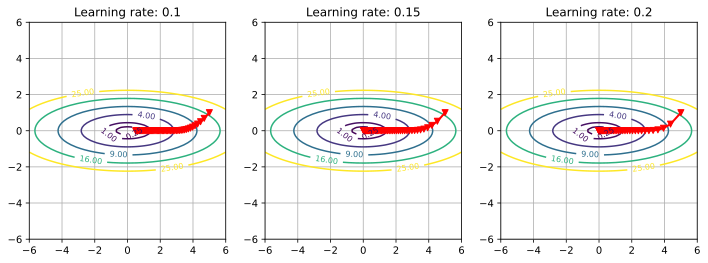

In [13]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

f = quadratic_form(np.array([[1,0],[0,10]]))



xrange = [-6, 6]
yrange = [-6, 6]
levels = [0, 0.25, 1, 4, 9, 16, 25]
        
x = np.linspace(xrange[0], xrange[1], 100)
y = np.linspace(yrange[0], yrange[1], 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i, j] = f.val(np.array([X[i, j], Y[i, j]]))

### Hyperparameters:
K = 50
lr_s = [0.1,0.15,0.2]
alpha = 0.9
eps = 1e-5
###

for ax_,lr in zip(ax,lr_s):
    
    CS = ax_.contour(X, Y, Z, levels=levels)
    ax_.clabel(CS, inline=1, fontsize=8) 
    ax_.grid()  
    
    x = np.array([5,1])
    history = [x]
    
    v = 0.
    
    for k in range(K):
        
        grad = f.grad(x)
        
        v = alpha*v + (1.-alpha)*(grad**2)
        
        x = x - lr*grad/(np.sqrt(v)+eps)
        
        history.append(x)

    history = np.array(history)
    ax_.plot(history[:,0],history[:,1],'-v', color='red', linewidth=2)
    ax_.set_title('Learning rate: '+str(lr))
    ax_.set_xlim(xrange)
    ax_.set_ylim(yrange)

We see that RMSprop, as momentum, also eliminates the oscillation problem of GD. Unlilke momentum methods, RMSprop does not have "inertia", so it does not overstep the minimum.

## Adam

**Adam** is one of the most popular optimization methods for neural networks. It combines the ideas of momentum and adaptive learning rate. An update of Adam algorithm is given by:

$$m^{(k+1)} = \alpha m^{(k)} + (1-\alpha)\nabla_w f(w^{(k)}), $$

$$v^{(k+1)} = \beta v^{(k)} + (1-\beta)\bigl(\nabla_w f(w^{(k)}) \bigr)^2, $$

$$\hat{m}^{(k+1)} = \dfrac{m^{(k+1)}}{1-\alpha^{k+1}},$$

$$\hat{v}^{(k+1)} = \dfrac{v^{(k+1)}}{1-\beta^{k+1}},$$

$$w^{(k+1)} = w^{(k)} - \eta \dfrac{\hat{m}^{(k+1)}}{\sqrt{\hat{v}^{(k+1)}}+\epsilon}$$

Here we have hyperparameters $\alpha$, $\beta$ and $\epsilon$, already discussed in the previous methods. Except for keeping the momentum and the second moment, Adam also performs a bias correction step. This step counteracts the effects of setting initial values of $m$ and $v$ to zero, so the bias correction mostly affects the beginning of training.

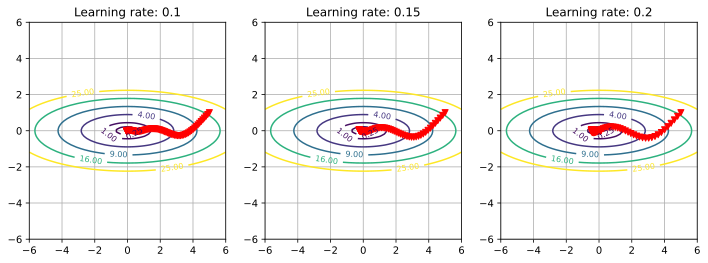

In [14]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

f = quadratic_form(np.array([[1,0],[0,10]]))



xrange = [-6, 6]
yrange = [-6, 6]
levels = [0, 0.25, 1, 4, 9, 16, 25]
        
x = np.linspace(xrange[0], xrange[1], 100)
y = np.linspace(yrange[0], yrange[1], 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i, j] = f.val(np.array([X[i, j], Y[i, j]]))

### Hyperparameters:
K = 100
lr_s = [0.1,0.15,0.2]
alpha = 0.99
beta = 0.9
eps = 1e-5
###

for ax_,lr in zip(ax,lr_s):
    
    CS = ax_.contour(X, Y, Z, levels=levels)
    ax_.clabel(CS, inline=1, fontsize=8) 
    ax_.grid()  
    
    x = np.array([5,1])
    history = [x]
    
    v = 0.
    prev_grad = 0.
    
    for k in range(K):
        
        grad = f.grad(x)
        
        v = alpha*v + (1.-alpha)*(grad**2)
        m = beta*prev_grad + (1.-beta)*grad
        
        _v = v/(1.-alpha**(k+1))
        _m = m/(1.-beta**(k+1))
        
        x = x - lr*_m/(np.sqrt(_v)+eps)
        
        history.append(x)
        
        prev_grad = m

    history = np.array(history)
    ax_.plot(history[:,0],history[:,1],'-v', color='red', linewidth=2)
    ax_.set_title('Learning rate: '+str(lr))
    ax_.set_xlim(xrange)
    ax_.set_ylim(yrange)

## Optimizing MLP 

We now compare the performance of all the discussed optimization methods on our MLP implementation from the previous class

### Activation functions

In [15]:
class ReLU:
    ''' ReLU activation and its sub-derivative. '''

    def val(self, y):
        return y*(y>0)

    def diff(self, y):
        return np.where(y>0,1,0)


class Linear:
    ''' Linear activation and its derivative. '''

    def val(self, y):
        return y

    def diff(self, y):
        return 1. 

### Loss functions

In [16]:
class L2:
    ''' Quadratic loss value and its derivative. '''

    def val(self, X, Y):
        return .5 * np.sum((X - Y)**2)/X.shape[0]

    def diff(self, X, Y):
        return (X - Y)/X.shape[0]

### Dense layer

In [17]:
class DenseLayer():
    def __init__(self, num_in, num_out, activation=ReLU):
        # number of in and out neurons
        self.num_in = num_in
        self.num_out = num_out
        
        self.activation = activation()
        
        # He initialization
        self.W = np.random.normal(loc=0.,scale=np.sqrt(2./num_in),size = (num_out, num_in)) 
        self.b = np.zeros((num_out,))
        
        self.prev_dW = 0.
        self.prev_db = 0.
        self.dW2 = 0.
        self.db2 = 0.
        self.train_iter = 1.


    def val(self, X):
        ''' Compute the activation of all output neurons. '''
        
        # pre-activation vector
        z = X@self.W.T + self.b
        
        # activation vector
        x = self.activation.val(z)
        
        return z, x
    
    def compute_delta(self, z, W_next, delta_next):
        '''Compute backpropagated error delta^l from delta^l+1'''
        delta = self.activation.diff(z)*(delta_next@W_next)
        return delta


    def gd_update(self,X_prev, delta, lr):
        
        '''Compute gradients using delta^l'''
        delta_W = np.mean(delta[:,:,np.newaxis]*X_prev[:,np.newaxis,:],axis=0)
        delta_b = np.mean(delta,axis=0)
        
        ''' Update rule for this layer. '''
        self.W -= lr * delta_W
        self.b -= lr * delta_b
    
    def momentum_update(self,X_prev, delta, lr, alpha=0.9):
        
        '''Compute gradients using delta^l'''
        delta_W = np.mean(delta[:,:,np.newaxis]*X_prev[:,np.newaxis,:],axis=0)
        delta_b = np.mean(delta,axis=0)
        
        '''Compute momentum'''
        m_W = alpha*self.prev_dW + (1.-alpha)*delta_W
        m_b = alpha*self.prev_db + (1.-alpha)*delta_b
        
        ''' Update rule for this layer. '''
        self.W -= lr * m_W
        self.b -= lr * m_b
        
        '''Save momentum for the next step'''
        self.prev_dW = m_W
        self.prev_db = m_b
        
    def rmsprop_update(self,X_prev, delta, lr, beta=0.9, eps=1e-8):
        
        '''Compute gradients using delta^l'''
        delta_W = np.mean(delta[:,:,np.newaxis]*X_prev[:,np.newaxis,:],axis=0)
        delta_b = np.mean(delta,axis=0)
        
        '''Compute second moment'''
        dW2 = beta*self.dW2 + (1.-beta)*(delta_W**2)
        db2 = beta*self.db2 + (1.-beta)*(delta_b**2)
        
        ''' Update rule for this layer. '''
        self.W -= lr * delta_W/(np.sqrt(dW2)+eps)
        self.b -= lr * delta_b/(np.sqrt(db2)+eps)
        
        self.dW2 = dW2 
        self.db2 = db2
        
    def adam_update(self,X_prev, delta, lr, alpha=0.9, beta=0.9, eps=1e-8):
        
        '''Compute gradients using delta^l'''
        delta_W = np.mean(delta[:,:,np.newaxis]*X_prev[:,np.newaxis,:],axis=0)
        delta_b = np.mean(delta,axis=0)
        
        '''Compute momentum'''
        m_W = alpha*self.prev_dW + (1.-alpha)*delta_W
        m_b = alpha*self.prev_db + (1.-alpha)*delta_b
        
        '''Compute unbiased momentum'''
        _m_W = m_W/(1.-alpha**self.train_iter)
        _m_b = m_b/(1.-alpha**self.train_iter)
        
        '''Compute second moment'''
        dW2 = beta*self.dW2 + (1.-beta)*(delta_W**2)
        db2 = beta*self.db2 + (1.-beta)*(delta_b**2)
        
        '''Compute unbiased second moment'''
        _dW2 = dW2/(1.-beta**self.train_iter)
        _db2 = db2/(1.-beta**self.train_iter)
        
        ''' Update rule for this layer. '''
        self.W -= lr * _m_W/(np.sqrt(_dW2)+eps)
        self.b -= lr * _m_b/(np.sqrt(_db2)+eps)
        
        self.prev_dW = m_W
        self.prev_db = m_b
        
        self.dW2 = dW2 
        self.db2 = db2
        
        self.train_iter += 1
        
    
    def update(self,X_prev, delta, lr, method='gd',**kwargs):
        if method=='gd':
            self.gd_update(X_prev, delta, lr)
        elif method=='momentum':
            self.momentum_update(X_prev, delta, lr, alpha=kwargs['alpha'])
        elif method=='rmsprop':
            self.rmsprop_update(X_prev, delta, lr, beta=kwargs['beta'], eps=1e-10)
        elif method=='adam':
            self.adam_update(X_prev, delta, lr, alpha=kwargs['alpha'], beta=kwargs['beta'], eps=1e-10)
        else:
            raise('Unknown method!')


### MLP class

In [18]:
class MLP():
    def __init__(self, widths, activation, output_activation=Linear, loss=L2):
        self.widths = widths
        self.layers = [DenseLayer(self.widths[l],self.widths[l+1],activation=activation) 
                       for l in range(len(self.widths)-2)]
        self.layers.append(DenseLayer(self.widths[-2],self.widths[-1],activation=output_activation) )
        self.loss = loss()
        
        self.history = [{'loss': None,
                         'accuracy': None}]
        
        self.train_started = 0
        
     
    def _labels_encoding(self, Y):
        self.labels = np.unique(Y)
        K = self.labels.size
        y_t = np.zeros(Y.shape+(K,))
    
        for k in range(K):
            ind = np.argwhere(Y==self.labels[k]).T.tolist()
            ind.append([k]*len(ind[0]))
            y_t[tuple(ind)] = 1

        return y_t
    
    def h(self,X):
        out = X
        for layer in self.layers:
            
            _, out = layer.val(out)

        return out
    
    def accuracy(self, X, Y):
        
        pred = np.argmax(self.h(X),axis=-1).ravel()
        return 1. - np.mean(self.labels[pred] != Y.ravel())
    
    def _loss(self, X, _Y):
        return self.loss.val(self.h(X),_Y)
    
    def forward_pass(self,X):
        x_l = [X]
        z_l = [X]
        for layer in self.layers:
            
            z, x = layer.val(x_l[-1])
            
            x_l.append(x)
            z_l.append(z)

        return z_l, x_l
    
    
    def train(self, X, Y,num_iter=10,lr=1e-3, method='gd',**kwargs):
 
        _Y = self._labels_encoding(Y)
    
        if self.train_started == 0:
            self.history[0]['loss'] = self._loss(X,_Y)
            self.history[0]['accuracy'] = self.accuracy(X,Y)
            self.train_started = 1
        
        for e in range(num_iter):
            
            z_l, x_l = self.forward_pass(X)

            L_diff = self.loss.diff(x_l[-1], _Y)
            delta_next = L_diff*self.layers[-1].activation.diff(z_l[-1])    
            delta_l = [delta_next]
            
            for i in reversed(range(1, len(self.layers)-1)):
                
                delta_next = self.layers[i].compute_delta(z_l[i+1],self.layers[i+1].W,delta_l[-1])
                delta_l.append(delta_next)

            delta_next = self.layers[0].compute_delta(z_l[1],self.layers[1].W,delta_l[-1])
            delta_l.append(delta_next)
            
            delta_l = delta_l[::-1]


            for i, layer in enumerate(self.layers):
                layer.update(x_l[i],delta_l[i],lr=lr,method=method,**kwargs)
             
            loss = self._loss(X,_Y)
            acc = self.accuracy(X,Y)
            self.history.append({'loss': loss,
                                 'accuracy': acc})
                         

We test our implementation on a two-dimensional projection of the Iris dataset.

In [43]:
file_name = 'iris_data_set.csv'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
column_names = ['sepal length [cm]', 'sepal width [cm]',
                'petal length [cm]', 'petal width [cm]', 'iris type']

if os.path.exists(file_name):
    print(f'Loading data from local file `{file_name}`...')
    df = pd.read_csv(file_name, index_col=0)
else:
    print(f'Loading data from `{url}`...')
    df = pd.read_csv(url, names=column_names)
    df.to_csv(file_name)
    print('Done.')

Loading data from local file `iris_data_set.csv`...


In [44]:
training_data_fraction = 0.8

df, train_df, test_df =  train_test_split(df, training_data_fraction)

X = df[['sepal length [cm]', 'petal width [cm]']].to_numpy()
Y = df['iris type'].to_numpy()

train_X = train_df[['sepal length [cm]', 'petal width [cm]']].to_numpy()
train_Y = train_df['iris type'].to_numpy()

test_X = test_df[['sepal length [cm]', 'petal width [cm]']].to_numpy()
test_Y = test_df['iris type'].to_numpy()

print('Training data split as follows:')
print(f'  Training data samples: {len(train_df)}')
print(f'      Test data samples: {len(test_df)}')

Training data split as follows:
  Training data samples: 120
      Test data samples: 30


In [51]:
widths = [X.shape[-1],100,np.unique(Y).size]

gd:
    The final train accuracy: 85.0%
    Test accuracy: 80.0%


momentum:
    The final train accuracy: 87.5%
    Test accuracy: 90.0%


rmsprop:
    The final train accuracy: 95.8%
    Test accuracy: 100.0%


adam:
    The final train accuracy: 94.2%
    Test accuracy: 100.0%




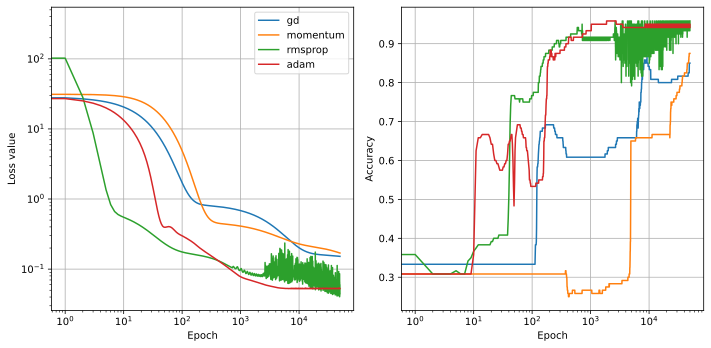

In [52]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

methods = ['gd','momentum','rmsprop','adam']

models = []
for method in methods:

    models.append(MLP(widths,activation=ReLU,output_activation=Linear,loss=L2))
    models[-1].train(train_X,train_Y,lr=1e-3,num_iter=50000,
                     method=method,alpha=0.9,beta=0.999)
    
    loss_history = [h['loss'] for h in models[-1].history]
    acc_history = [h['accuracy'] for h in models[-1].history]

    ax[0].plot(range(len(models[-1].history)), loss_history, label=method)
    ax[1].plot(range(len(models[-1].history)), acc_history, label=method)
    
    print(method+':')
    print(f'    The final train accuracy: {round(100*acc_history[-1],1)}%')
    print(f'    Test accuracy: {round(100*models[-1].accuracy(test_X, test_Y),1)}%')
    print('\n')

ax[0].set_ylabel('Loss value')
ax[0].set_yscale('log')
ax[0].set_xscale('log')

ax[1].set_xscale('log')

ax[1].set_ylabel('Accuracy')

ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')

ax[0].grid()
ax[1].grid()

ax[0].legend()

fig.tight_layout()

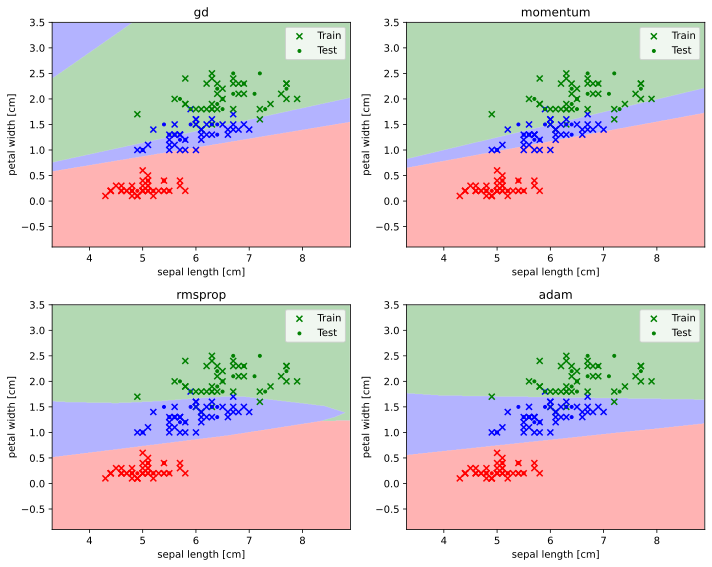

In [53]:
fig, ax = plt.subplots(2,2, figsize=(10,8))

x1_min = train_X[:, 0].min() - 1
x1_max = train_X[:, 0].max() + 1
x2_min = train_X[:, 1].min() - 1
x2_max = train_X[:, 1].max() + 1

x1_list, x2_list = np.meshgrid(np.arange(x1_min, x1_max, .01), 
                               np.arange(x2_min, x2_max, .01))

X_list = np.dstack([x1_list, x2_list])

for _ax, method, model in zip(ax.ravel(),methods,models):

    h_list = np.argmax(model.h(X_list),axis=-1)

    cmap = matplotlib.colors.ListedColormap(['red', 'blue', 'green'])
    _ax.contourf(x1_list, x2_list, h_list, cmap=cmap, alpha=.3)

    colors = train_df['iris type'].replace(model.labels,['red','blue','green'])
    _ax.scatter(train_X[:, 0], train_X[:, 1], marker='x',color=colors, label='Train')

    colors = test_df['iris type'].replace(model.labels,['red','blue','green'])
    _ax.scatter(test_X[:, 0], test_X[:, 1], marker='.',color=colors, label='Test')


    _ax.set_xlabel('sepal length [cm]')
    _ax.set_ylabel('petal width [cm]')
    _ax.set_xlim(x1_min, x1_max)
    _ax.set_ylim(x2_min, x2_max)
    _ax.legend()
    
    _ax.set_title(method)
    
fig.tight_layout()

# Exercise

Load the MNIST dataset and train an MLP model on it using the new optimization methods. Since MNIST is much larger than the Iris dataset, you will need to add a stochastic (mini-batch) version of the training method. 

Does the performance improve in comparison with GD training? Does the training time change?